# SEGA or Variance Reduction via Gradient sketching
## Problem statement
The method is used for solving following optimization problems:
\begin{equation}
\min_{x \in \mathbb{R}^d} F(x) \stackrel{\text{def}}{=} f(x) + R(x),
\end{equation}
where $f : \text{R}^d → \text{R}$ is smooth and µ–strongly convex, and $R : \text{R}^d → \text{R} \cup \{+∞\}$ is a closed convex regularizer with available [proximal operator](https://en.wikipedia.org/wiki/Proximal_operator) defined as
\begin{equation}
\text{prox}_{\alpha R} (x) \stackrel{\text{def}}{=} \underset{y}{\mathrm{argmin}} (R(y) + \frac{1}{2\alpha} ||y-x||_\text{B}^2)
\end{equation}
Here, B is a positive definite weight matrix such that $||x||^2_\text{B} = \langle \text{B}x,x \rangle$.\
\
Also, we have only the __linear transformation__ of true gradient available at any moment, so \begin{equation}
\zeta (S,x)
\stackrel{\text{def}}{=} S^T\nabla f(x), \quad S \sim D, S \in \text{R}^{\text{d x b}}, x\in \text{R}^\text{d}
\end{equation}
It means, we have some distribution of linear transformation D, and every time we ask for the gradient, oracle samples the linear transformation S from D, applies it to the gradient and gives us the result. For example, D can be the distribution over base vectors or vectors over gaussian distribution.

## The first experiment
First, we will work with the optimization problem of logistic regression to test the method and compare it to Coordinate descent. \
Here, we will optimize parameters __w__ to minimize the function F(w). Lets define the function F(w):
\begin{equation}
F(w) = \frac{1}{n} \sum\limits_{i=1}^n \ln (1 + e^{-y_iw^Tx_i}) + \frac{\lambda}{2} \| w \|^2_2
\end{equation}
The normalized sum of logs is the __f(w)__, and L2 regularizer is the __R(w)__. The parameter $\lambda$ will be 0.005. The derivative of the function f(w) is
\begin{equation}
\nabla f(w) = -\frac{1}{n} \sum\limits_{i=1}^n \frac{y_ix_i}{1 + e^{y_iw^Tx_i}}
\end{equation}
X and y are taken from the [__mushrooms__ dataset](https://github.com/porludom/Variance-reduction-via-gradient-sketching/blob/main/mushrooms.txt), where $y \in \{-1,1\}$\
For the rest of the colab, D is the distribution over standard basis vectors, because we want to compare it to coordinate descent that also uses gradient-descent in the direction of base vectors.\
Also, B is chosen to be just the identity matrix.

### Some preparation: imports and loading of dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
sns.set_theme()

In [ ]:
# Here we install the dataset.
%%capture
!wget https://raw.githubusercontent.com/porludom/Variance-reduction-via-gradient-sketching/main/mushrooms.txt

In [ ]:
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = 2 * y - 3 # initially y are in {0,1}. we transform them to {-1,1}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def f(X : np.ndarray, y : np.ndarray, w : np.ndarray):
    n = X.shape[0]
    f = 0
    for i in range(n):
        f += np.log(1 + np.exp(-y[i] * (w.transpose() @ X[i])))
    return f / n

In [ ]:
def grad_f(X : np.ndarray, y : np.ndarray, w : np.ndarray):
    n = X.shape[0]
    gr = np.zeros(X.shape[1]).reshape(-1,1)
    for i in range(n):
        gr += (y[i] * X[i].reshape(-1,1)) / ( 1 + np.exp(y[i] * (w.transpose() @ X[i])))
    return -gr / n

#SEGA algorithm for logistic regression
Here lets define algorithm-related function for the case of logistic regression

In [ ]:
def sample_S_from_D(d : int):
  '''

  Here, D is the distribution over standart basis vectors in R^d.
  Returns the sampled unit vector.
  '''
  chosen_component = np.random.choice(range(d))
  vec = np.zeros(d)
  vec[chosen_component] = 1
  return vec.reshape(-1,1), chosen_component

In [ ]:
def calculate_Z_k(S_k, B_inv):
  '''
  calculation of Z_k using paper
  '''
  return S_k @ (S_k.T @ B_inv @ S_k).T @ S_k.T

In [ ]:
def proximal_for_L2_squared(w : np.ndarray, lam, alpha = 1):
  '''
  alpha - the stepsize for proximal operator
  lambda - the coefficient for regularizer

  Returns the result of proximal step
  '''
  return w / (1 + lam * alpha) #please check chapter 4.2 for proofs: https://cims.nyu.edu/~cfgranda/pages/MTDS_spring19/notes/convex_optimization.pdf

## SEGA
During the training, we will use as the criterion the fraction of squared second norm of gradient at initial point and point x_k.


In [ ]:
d = X_train.shape[1] # dimensionality of parameter vector that is equal to dim. of x vector, because we do dot product in the model

B = np.eye(d) # Depends on your task
B_inv = np.eye(d)

lam = 0.00525
L = 5.25 + lam

In [ ]:
iterations = 1000
losses_SEGA = [1]
x_0 = np.ones((d, 1)) # Same for sega and CD
x_k = x_0.copy()
h_k = np.zeros((d, 1)) # global estimation that we will correct

norm_of_gradient_at_start = np.linalg.norm(grad_f(X_train, y_train, x_k))**2
step_size = 1 / L

for iteration in trange(iterations):
  S_k, component = sample_S_from_D(d) # sample transformation

  Z_k = calculate_Z_k(S_k, B_inv)
  some_expression = S_k * (grad_f(X_train, y_train, x_k)[component][0] - h_k[component][0]) # This is the common part for h and g

  g_k = h_k + d * some_expression

  x_k -= step_size * g_k
  x_k = proximal_for_L2_squared(x_k, lam, step_size)

  h_k = h_k + some_expression

  if np.linalg.norm(grad_f(X_train, y_train, x_k))**2 > 2: #stop criteria if something is wrong
    break

  losses_SEGA.append(np.linalg.norm(grad_f(X_train, y_train, x_k))**2)

100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]


## CD
Coordinate descent is the gradient descent applied in the direction of such basis vector that has the best descent.

In [ ]:
losses_CD = [1]
x_0 = np.ones((d, 1)) # Same for sega and CD
x_k = x_0.copy()
iterations = 1000

norm_of_gradient_at_start = np.linalg.norm(grad_f(X_train, y_train, x_k))**2
step_size = 1 / L
for iteration in trange(iterations):
  grad = grad_f(X_train, y_train, x_k)
  sampled_component = np.argmax(abs(grad)) # pick the best component
  g = np.zeros((d,1))
  g[sampled_component][0] = grad[sampled_component][0]
  x_k -= step_size * g
  x_k = proximal_for_L2_squared(x_k, lam, step_size)

  losses_CD.append(np.linalg.norm(grad_f(X_train, y_train, x_k))**2)

100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


## Comparison

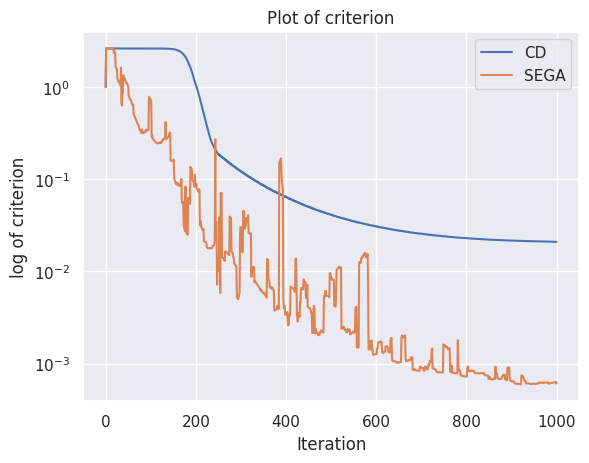

In [ ]:
plt.plot(range(len(losses_CD)), losses_CD)
plt.plot(range(len(losses_SEGA)), losses_SEGA)
plt.title("Plot of criterion")
plt.xlabel("Iteration")
plt.ylabel("log of criterion")
plt.yscale("log")
plt.legend(["CD", "SEGA"])